## MLFlow

Homework (block 7, part 1) MLOps3 course

### Description

Objective: to explore the capabilities of MLFlow to
 - log parameters, metrics and models;
 - compare experiments;
 - select the best option.

Take the dataset ["Amazon reviews"](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews) as input data and leave only 50000 rows. Perform data preprocessing and vectorization. Train two classification models (Logistic Regression and Random Forest) and provide logging using MLFlow. Perform comparison and select the best model.

Python scripts are available in project folder: `mlops3/mlflow/`.

In [1]:
import re
import pandas as pd

from zipfile import ZipFile

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import classification_report

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from sklearn.metrics import (
    ConfusionMatrixDisplay,
)

import warnings

warnings.filterwarnings('ignore')

### Dataset

Load data and prepare it ot precessing.

In [13]:
!kaggle datasets download -d kritanjalijain/amazon-reviews

Dataset URL: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews
License(s): CC0-1.0
amazon-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
zip_file = ZipFile("amazon-reviews.zip")
df = pd.read_csv(
    zip_file.open("train.csv"),
    nrows=50000,
    header=None,
    names=['Polarity', 'Title', 'Review'],
)
df.head()

Polarity                                              Title  \
0         2                     Stuning even for the non-gamer   
1         2              The best soundtrack ever to anything.   
2         2                                           Amazing!   
3         2                               Excellent Soundtrack   
4         2  Remember, Pull Your Jaw Off The Floor After He...   

                                              Review  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...

In [4]:
df['Polarity'] = df['Polarity'].map({1: 0, 2: 1})
df.Polarity.value_counts()

Polarity
1    25506
0    24494
Name: count, dtype: int64

### Preprocessing

The function cleans out links, special characters and leaves only letters. Test it on a single row of data, apply to column "Review" and put result in column "corpus".

In [11]:
def preprocessing(input_text: str) -> str:
    text = input_text.lower()
    text = re.sub(
        r'https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*', '', text
    )
    text = re.sub("[0-9 \-_]+", " ", text)
    text = re.sub("[^a-z A-Z]+", " ", text)
    return text.strip()


print("Original: ", df.Review[0], "\n")
print("Preprocessed: ", preprocessing(df.Review[0]))

df['corpus'] = df['Review'].apply(preprocessing)

Original:  This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^ 

Preprocessed:  this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen


### TF-IDF

Split the data into training and test samples. Train the TF-IDF vectorizer on the training part and apply it to the test part.

In [6]:
vectorizer_params = {"max_features": 10000, "analyzer": "word"}

tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)

train, test = train_test_split(
    df,
    test_size=0.3,
    shuffle=True,
    random_state=13,
)

tfidf_vectorizer.fit(train["corpus"])
train_features = tfidf_vectorizer.transform(train["corpus"])
test_features = tfidf_vectorizer.transform(test["corpus"])

train_features, test_features

(<35000x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 1733148 stored elements in Compressed Sparse Row format>,
 <15000x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 735034 stored elements in Compressed Sparse Row format>)

### Experiments

First of all, open separate shell and run MLFlow Server in local mode: `mlflow server --host 127.0.0.1 --port 8080`

After that perform initialize of MLFlow tracking. Assign the name to "experiment" (group of "runs"). And write an auxiliary function to display confusion matrix.

In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
experiment = mlflow.set_experiment("TF-IDF_embeddings_50k")


def conf_matrix(y_true: np.ndarray, pred: np.ndarray) -> Figure:
    plt.ioff()
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_true, pred, ax=ax, colorbar=False
    )
    ax.xaxis.set_tick_params(rotation=90)
    _ = ax.set_title(f"Confusion Matrix")
    plt.tight_layout()
    return fig

#### Logistic Regression

Registered model 'sk-learn-reg-model' already exists. Creating a new version of this model...
2024/05/15 23:01:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-reg-model, version 7
Created version '7' of model 'sk-learn-reg-model'.


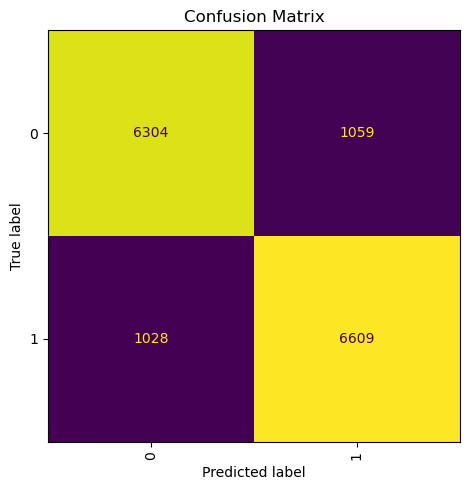

In [8]:
run_name = "logistic-regression"

model_params = {
    "multi_class": "multinomial",
    "solver": "saga",
    "random_state": 13,
}

model = LogisticRegression(**model_params)

with mlflow.start_run(run_name=run_name) as run:

    model.fit(train_features, train["Polarity"])
    predicts = model.predict(test_features)

    report = classification_report(
        test["Polarity"], predicts, output_dict=True
    )
    signature = infer_signature(test_features, test["Polarity"])

    mlflow.log_metric("accuracy", report.pop("accuracy"))
    mlflow.log_metric("f1-weighted", report["weighted avg"]["f1-score"])
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)

    mlflow.log_params(vectorizer_params)
    mlflow.log_params(model_params)

    mlflow.sklearn.log_model(
        sk_model=model,
        input_example=test_features[:10],
        artifact_path=f"mlflow/{run_name}/model",
        signature=signature,
        registered_model_name="sk-learn-reg-model",
    )

    fig = conf_matrix(test["Polarity"], predicts)

    mlflow.log_figure(fig, f'{run_name}_confusion_matrix.png')

#### Random Forest

In [9]:
run_name = "random-forest"

model_params = {
    "n_estimators": 100,
    "random_state": 13,
}

model = RandomForestClassifier(**model_params)

with mlflow.start_run(run_name=run_name) as run:

    model.fit(train_features, train["Polarity"])
    predicts = model.predict(test_features)

    report = classification_report(
        test["Polarity"], predicts, output_dict=True
    )
    signature = infer_signature(test_features, test["Polarity"])

    mlflow.log_metric("accuracy", report.pop("accuracy"))
    mlflow.log_metric("f1-weighted", report["weighted avg"]["f1-score"])
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)

    mlflow.log_params(vectorizer_params)
    mlflow.log_params(model_params)

    mlflow.sklearn.log_model(
        sk_model=model,
        input_example=test_features[:10],
        artifact_path=f"mlflow/{run_name}/model",
        signature=signature,
        registered_model_name="sk-learn-reg-model",
    )

    fig = conf_matrix(test["Polarity"], predicts)

    mlflow.log_figure(fig, f'{run_name}_confusion_matrix.png')

Registered model 'sk-learn-reg-model' already exists. Creating a new version of this model...
2024/05/15 23:03:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-reg-model, version 8
Created version '8' of model 'sk-learn-reg-model'.


#### Best model

Inside MLFlow UI ([http://127.0.0.1:8080/#/models](http://127.0.0.1:8080/#/models)) compare models and assign alias (e.g., "@champion") to the best one. 

Choosen model can be loaded and perform prediction.

In [12]:
import mlflow.pyfunc

model_name = "sk-learn-reg-model"
alias = "champion"

champion_version = mlflow.pyfunc.load_model(f"models:/{model_name}@{alias}")

print("Prediction: ", champion_version.predict(test_features[0]))

Prediction:  [1]


### Screenshots

#### Experiments and runs
![](images/mlflow_screenshot_1.jpeg)

#### Logistic Regression

![](images/mlflow_screenshot_2.jpeg)

#### Random Forest

![](images/mlflow_screenshot_3.jpeg)

#### Model comparison

![](images/mlflow_screenshot_4.jpeg)

#### Best model

![](images/mlflow_screenshot_5.jpeg)